In [172]:
## 2018113003
## Kalp Shah

# Ising Model
Ising model is one of the more famous models in statistical physics. The system studied in the model has 'spins' located at vertices of a (possibly infinite) lattice, and spins interact with their neighbours using a specific rule (like spins stabilize the energy and unlike spins destabilize the energy) and iteract with external field B; thus  the energy of the system is given as: 
$$ U = - \sum_i B\sigma_i - \frac{1}{2} \sum_{\langle i,j \rangle} J \sigma_i \sigma_j
$$
In the simple version of the model, $\sigma_i = \pm 1$, and system is maintained at temperature $T$; the probability of a particular configuration is given by the Boltzmann Probability Law:
    $$ P(\{\sigma_i\}_{i=1}^N) \propto \exp\left[-\beta U(\{\sigma_i\})\right]
$$

Clearly the probability is then given by 
$$ P(\{ \sigma_i\}_{i=1}^N) \propto \exp\left[ \frac{B}{kT} \sum_i \sigma_i + \frac{J}{2kT}\sum_{\langle i,j\rangle} \sigma_i \sigma_j    \right]
$$
and hence depends on numerical values of  $\frac{B}{kT}$ and $\frac{J}{2kT}$. 

## Periodic Boundary Conditions
To simulate a infinite system, it is common to use Periodic Boundary Conditions (PBC). As illustraition consider 1-dimensional (1D) lattice, which is nothing but a straight line, with $N$ spins placed with equal spacing between two contigious spins. This chain of spins has left-end and right-end making this a finite system; however if we place this chain of spins on a circle such that in addition to requiring that distance between contigious spins is 1 unit, we require the distance betwen left-end and right-end of chain is 1 unit. We now see that the chain becomes *infinite*.

You can imagine similar trick in 2 dimensions, by requiing PBC in x-direction and y-directions. And, in 3-dimensions, requiring PBC in x-direction, y-direction and z-directions. 

### A specific trick applicable only for Ising Model for periodic boundary conditions
Add one extra row and one extra column to the configuration; the additional column/row is the copy of first column/row. 

## For Ising model, write following functions. Assume 2-dimensional model.
Set $J=1$ without loss of generality. See http://web.mit.edu/krish_s/www/files/ising_Model.pdf  page-27 has $m\, vs\, T$ plot

1. Write function to compute energy (using periodic boundary conditions): `Ising2D_Energy`
3. Write a function for magnetisation `Ising_Magnetisation` for $m(T,B)$
4. Write a function for computing heat capacity `Ising_HeatCapacity` for $C_V(T,B)$: $$C_V = \frac{1}{k_B T^2}\langle (E-\bar{E})^2\rangle = \frac{1}{k_B T^2} \left( \langle E^2 \rangle - \langle E \rangle^2 \right)$$
5. Write a function `Ising_SingleFlip_Metropolis` to perform one step of Metroplis Monte Carlo simulation
6. Write a function  `Ising_StoreConfig` to store configuration
7. Perform Monte Carlo Simulation of Ising Model
8. Plot $m(T,B=0)$ vs. $kT/J$. Hint: $kT/J \approx 2.5$ for critical temperature of Ising model. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants

## Periodic Boundary Conditions
Each object has two parameters xr and yr which represent the amount of times the configuration is repeated before wrapping around in a circle in x and y direction respectively

In [112]:
class Ising:
    def __init__(self,x,y,B=1.0,J=1.0,M=1.0,kT=1.0,xr=2,yr=2):
        ''' The initialization of the Ising class object, the enteries in order are x-length, y-length, Magnetic Field, Coupling Factor, Mu, kT, Periodic Boundary conditions x and y '''
        self.xlen = x
        self.ylen = y
        #Default Config
        self.config = np.ones((x,y),dtype=int)
        #Characteristic properties --> Optional (Defaults already present)
        self.mag = B
        self.coup = J
        self.mu = M
        self.kT = kT
        self.xr = xr
        self.yr = yr
        self.prob = 0
        
    def __str__(self):
        ''' Returns the configuration when the object is printed'''
        return str(self.config)
    
    def reset(self):
        ''' Reset the configuration to all ones'''
        self.config = np.ones((self.xlen,self.ylen),dtype=int)
        returno11111
        
    def random(self):
        ''' Randomizes the configurations'''
        for i in range(self.xlen):
            for j in range(self.ylen):
                if np.random.randint(2) == 0 :
                    self.config[i][j] = -1
                else:
                    self.config[i][j] = 1
        
    def magnetization(self):
        ''' Returns the magnetization of the current configuration'''
        return self.mu*np.sum(self.config)/(self.xlen*self.ylen)
    
    def energy(self):
        ''' Calculates the energy of the current configuration od the given Ising model'''
        # Potential only fron magnetic field
        V = -1 * self.mag * np.sum(self.config)
        V *= self.xr + self.yr - 1
        
        # Potential from interactions
        # For the interactions coupling with only the element below it and after it is considered 
        # so as to not have any duplications
        temp = 0
        temp1=0
        temp2=0
        for i in range(self.xlen):
            for j in range(self.ylen):
                if i != self.xlen - 1:
                    temp -= self.config[i][j] * self.config[i+1][j]
                if j != self.ylen - 1:
                    temp -= self.config[i][j] * self.config[i][j+1]
        temp *= (self.xr + self.yr - 1)
        
        #Applying PBC conditions
        for j in range(self.ylen):
            temp1 -= self.config[-1][j] * self.config[0][j]
        temp1 *= self.xr
        
        for j in range(self.xlen):
            temp2 -= self.config[j][-1] * self.config[j][0]
        temp2 *= self.yr
        
        temp += temp1 + temp2
        #Complete energy due to Coupling
        temp*=self.coup
        
        #Total Energy
        V += temp
        return V
        
        
    def MC(self):
        nx = np.random.randint(0,self.xlen)
        ny = np.random.randint(0,self.ylen)
        
        SumSpin=0
        
        if nx!=self.xlen-1:
            SumSpin+=self.config[nx+1][ny]
        else:
            SumSpin+=self.config[0][ny]
        if ny!=self.ylen-1:
            SumSpin+=self.config[nx][ny+1]
        else:
            SumSpin+=self.config[nx][0]
        if nx!=0:
            SumSpin+=self.config[nx-1][ny]
        else:
            SumSpin+=self.config[-1][ny]
        if ny!=0:
            SumSpin+=self.config[nx][ny-1]
        else:
            SumSpin+=self.config[nx][-1]        
        
        V = self.config[nx,ny]*(self.mag*self.mu*2 + self.coup*SumSpin)
        #Due to the PBC, multiple changes happen at once
        #Hence Potential =
        V *= self.xr + self.yr -1
        p_acc = np.exp(-1.0/self.kT*V)
        if V < 0 or np.random.random() < p_acc:
            self.config[nx,ny]*=-1
            accept=True
        else:
            accept=False
        self.prob = p_acc
        return accept
    
    def Store(self,stepSize,totStep,filename):
        f = open(filename, "w")
        fa = open("Config.dle", "w")
        f.write("Step No:Magnetization:Temp:Energy\n")
        fa.write("Config according to step\n")
        Step=0
        while Step < totStep:
            flag = self.MC()
            if flag == True:
                Step+=1
                if Step%stepSize == 0:
                    rem_temp = str(self.config) + "\n\n"
                    fa.write(rem_temp)
                    temp_str = str(Step) + ":" + str(self.magnetization()) + ":" + str(self.kT/scipy.constants.k) + ":" + str(self.energy()) + "\n"
                    f.write(temp_str)
        f.close()
        fa.close()
        
    def Heat(self,stepSize,totStep):
        Step=0
        E=0
        U=0
        while Step < totStep:
            flag = self.MC()
            if flag == True:
                Step+=1
                if Step%stepSize == 0:
                    temp=self.energy()
                    E+=temp
                    U+=temp*temp
        totEnergy= U - E*E
        totEnergy/=Step
        C = totEnergy/(self.kT*self.kT)
        return C            
    
    def Mag_Step(self,stepSize,totStep):
        Step=0
        E=0
        U=0
        while Step < totStep:
            flag = self.MC()
            Step+=1
            if Step%stepSize == 0:
                E = self.magnetization()
        E/=Step
        return E   
    
    def equiibration(self,steps):
        x = np.array([])
        y = np.array([])
        i = 0
        while i < steps * self.xlen * self.ylen * (self.xr + self.yr - 1)
            flag = modObj.MC()
            val = modObj.energy()
            x=np.append(x,val)
            y = np.append(y,i)
            i+=1
        return [x,y]

SyntaxError: invalid syntax (<ipython-input-112-0d48dc279af9>, line 164)

## Brief
In the following code, an object for the Ising model is created with sie of 50 x 50 

In [35]:
modObj = Ising(50,50,0)
#modObj.random()
#modObj.kT=2.5
print(modObj)
modObj.mag = 0 
modObj.energy()

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


-14900.0

## Brief
The plot of the equilibration of the Energy

In [107]:
step = 100
totStep = 2000
modObj.kT = 1
modObj.random()
x = np.array([])
y = np.array([])
i = 0
while i < 20000:
    flag = modObj.MC()
    val = modObj.energy()
    x=np.append(x,val)
    y = np.append(y,i)
    i+=1

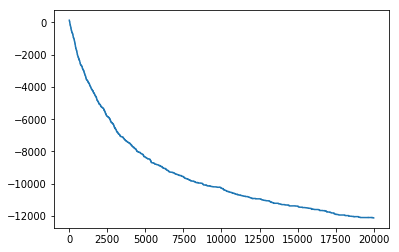

In [109]:
plt.plot(y,x)

## Brief
In the following code $m$ vs $k_bT$ is plotted

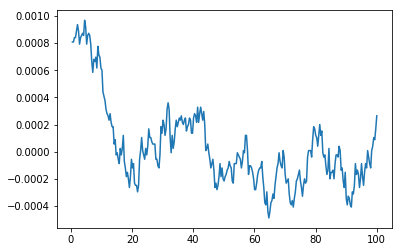

In [62]:
modObj.mag = 0
step = 100
totStep = 100
finTemp = 100
minTemp = 0.5
x = np.array([])
y = np.array([])
for i in np.linspace(minTemp,finTemp,300):
    modObj.kT = i
    val = modObj.Mag_Step(step,totStep)
    x=np.append(x,val)
    y = np.append(y,i)
plt.plot(y,x)

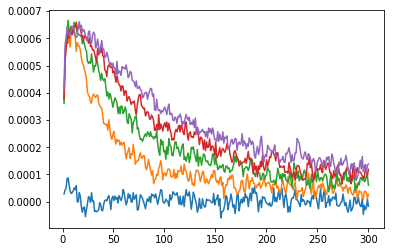

In [335]:
for j in np.linspace(0,5,5):
    modObj.mag = j
    modObj.random()
    step = 100
    totStep = 1000
    finTemp = 300
    minTemp = 1.5
    x = np.array([])
    y = np.array([])
    for i in np.linspace(minTemp,finTemp,300):
        modObj.kT = i
        val = modObj.Mag_Step(step,totStep)
        x=np.append(x,val)
        y = np.append(y,i)
    plt.plot(y,x)

In [ ]:
modObj.reset()
modObj.Mag_Step(100,1000)

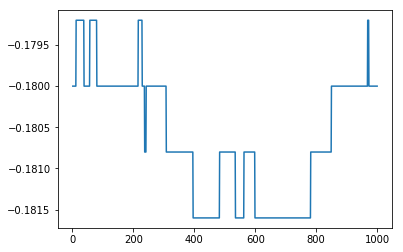

In [106]:
x = np.array([])
y = np.array([])
i=0
while i < 1000:
    flag = modObj.MC()
    i+=1
    x = np.append(x,i)
    y = np.append(y,modObj.magnetization())
        
plt.plot(x,y)

In [101]:
modObj.magnetization()

-0.1824

In [96]:
modObj.energy()

-14900.0